Here we inspect the dataset sent by Ishihara-san on 25th of February, 2025. Here is a little description of the dataset:

Inside the SSD, the mtr folder contains X-ray absorption coefficient images acquired at each rotational angle (raw data, image size: 4096 pixels wide × 2304 pixels high, 32-bit real). The first image in the sequence corresponds to the -90-degree data, while the 1800th image corresponds to the +90-degree data. The images are acquired at 0.1-degree intervals in between.

The rec folder contains reconstructed data obtained using a general reconstruction method called filtered back projection, based on the mtr data mentioned above.

In [10]:
import numpy as np
import glob
import os
import cv2 
from tqdm import tqdm

# Folder containing raw projection files
folder_path = '/mnt/8T_HDD1/Workspace/2025_02_25_data/mtr'
original_shape = (2304, 4096)
num_projections = 1800

# Check if the directory exists
if not os.path.exists(folder_path):
    raise FileNotFoundError(f"Directory not found: {folder_path}")

In [11]:
# Define new resized dimensions while keeping aspect ratio
new_height = 256  # You can change this based on your needs
aspect_ratio = original_shape[1] / original_shape[0]  # 4096 / 2304 = 1.78
new_width = int(new_height * aspect_ratio)  # Compute new width

new_shape = (new_height, new_width)  # New resized shape
print(f"Resizing images to: {new_shape}")

Resizing images to: (256, 455)


In [13]:
# Get all raw files and sort them
raw_files = sorted(glob.glob(os.path.join(folder_path, "*.raw")))

# Ensure we have the expected number of files
assert len(raw_files) == num_projections, f"Expected {num_projections} files, but found {len(raw_files)}"

# Load all projections, resize while keeping aspect ratio
projections = np.array([
    cv2.resize(
        np.fromfile(f, dtype=np.float32).reshape(original_shape), 
        (new_width, new_height),  # OpenCV uses (width, height)
        interpolation=cv2.INTER_AREA
    ) for f in tqdm(raw_files)
])

print("Loaded resized projections shape:", projections.shape)


  0%|          | 0/1800 [00:00<?, ?it/s]

100%|██████████| 1800/1800 [04:24<00:00,  6.79it/s]


Loaded resized projections shape: (1800, 256, 455)


Now we inspect a little bit the projections

In [15]:
import matplotlib.pyplot as plt

save_folder = "../data/2025_02_25"

# Save every 10th view
for i in tqdm(range(0, projections.shape[0], 10)):  # Step size = 10
    save_path = os.path.join(save_folder, f"view_{i:04d}.png")  # Format: view_0000.png, view_0010.png, etc.
    plt.imsave(save_path, projections[i], cmap="gray")  # Save as grayscale PNG

print(f"Saved {projections.shape[0] // 10} images in '{save_folder}'")


100%|██████████| 180/180 [00:06<00:00, 27.39it/s]

Saved 180 images in '../data/2025_02_25'


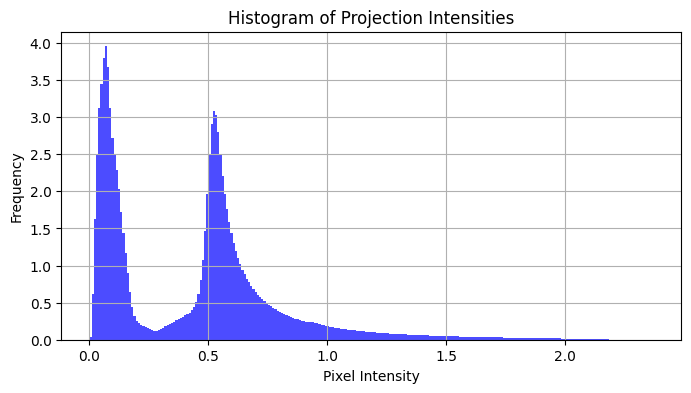

In [19]:
def draw_histogram(data):
    pixel_values = data.flatten()
    plt.figure(figsize=(8, 4))
    plt.hist(pixel_values, bins=256, color='blue', alpha=0.7, density=True)  # Normalized histogram
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.title("Histogram of Projection Intensities")
    plt.grid(True)
    plt.show()

draw_histogram(projections)

Now we inspect the reconstructed volume they gave us using filtered backward projection (FBP).
The volume consists of 2304 slices with size 4096; so the final shape is 2304x4096x4096.

In [36]:
import os
import numpy as np
from PIL import Image
from natsort import natsorted

folder_path = '/mnt/8T_HDD1/Workspace/2025_02_25_data/rec'
tif_files = natsorted([f for f in os.listdir(folder_path) if f.endswith('.tif')])

volume = [''] * len(tif_files)
for idx, filename in enumerate(tqdm(tif_files)):
    img = Image.open(os.path.join(folder_path, filename))
    img_resized = img.resize((256, 256))
    volume[idx] = np.array(img_resized)

volume_array = np.stack(volume, axis=0)
volume_array.shape

100%|██████████| 2304/2304 [15:53<00:00,  2.42it/s]


(2304, 256, 256)

In [34]:
volume[1].shape

(4096, 4096)